# Caderno com o modelo 1 - partição 1

- VGG19 

- O trabalho busca classificar imagens de pessoas nas seguintes classes:
  

1.   pessoas sem máscara
2.   pessoas com máscara incorreta 
3.   pessoas com máscara correta




In [1]:
# Usaremos a GPU
import tensorflow as tf

In [2]:
# tf.test.is_gpu_available()
len(tf.config.list_physical_devices('GPU'))

1

In [3]:
print(tf.__version__)

2.6.0


# Bibliotecas

In [4]:
#from tensorflow.keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization,Activation, MaxPooling2D, Flatten, Dense,Dropout
from keras.models import Model, load_model
from keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import imutils
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
from PIL import Image
import pathlib

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

- Carregando o dataset de treino

In [6]:
dataset = os.path.join(os.getcwd(), 'D:/TCC/1/p1') #Onde estão a pasta train e test
# Dataset


tamanho_treinamento_com_errada = len(os.listdir(os.path.join(dataset,'incorreta')))
tamanho_treinamento_com_certa = len(os.listdir(os.path.join(dataset,'correta')))
tamanho_treinamento_sem = len(os.listdir(os.path.join(dataset,'sem')))

print("Classe 1 - sem: " + str(tamanho_treinamento_sem))
print("Classe 2 - incorreta: " + str(tamanho_treinamento_com_errada))
print("Classe 3 - correta: " + str(tamanho_treinamento_com_certa))

# Internamente como é mapeado classe indice vetor:
# 0 correta
# 1 incorreta
# 2 sem

Classe 1 - sem: 8000
Classe 2 - incorreta: 7624
Classe 3 - correta: 7683


In [7]:
ditribuicao_dataset = {'1-Sem': [tamanho_treinamento_sem],'2-Incorreta': [tamanho_treinamento_com_errada],'3-Correta':[tamanho_treinamento_com_certa]}
# Criando um dataframe
df_ditribuicao_dataset = pd.DataFrame(ditribuicao_dataset, index=['total'])
df_ditribuicao_dataset

,1-Sem,2-Incorreta,3-Correta
total,8000,7624,7683


# Hiper-parâmetros

- imagem

In [8]:
image_width = 150
image_height = 150
image_color_channel = 3
image_size = (image_width, image_height)
image_shape = image_size + (image_color_channel,)
image_color_channel_size = 255
batch_size = 32

# Pré-processamento

o 1º problema é que algumas fotos podem estar corrompidas. Iremos excluí-las conforme
ensinado em https://keras.io/examples/vision/image_classification_from_scratch/

Adotaremos a separação do conjunto original em 3 partes: Treinamento, Validação e Teste.

- O conjunto de Treinamento será utilizado para o processo de aprendizado,
- O conjunto de Validação será utilizado para o ajuste de parâmetros, depois de cada época,
- O conjunto de Teste será utilizado para avaliar o modelo final.

Para isso, o conjunto de treinamento será separado em 90% como treinamento e 10% como validação

### Forma: meu próprio pipeline 

- Construir manualmente um tf.data.Dataset semelhante ao criado por tf.keras.utils.image_dataset_from_directory
- Aqui, conseguirei dividir o dataset em treino e teste

- Segui o descrito em: https://www.tensorflow.org/tutorials/load_data/images

In [9]:
data_dir_1 = pathlib.Path(dataset)
data_dir_1

WindowsPath('D:/TCC/1/p1')

In [10]:
image_count = len(list(data_dir_1.glob('*/*')))   #ou .jpg
print(image_count)

23307


In [11]:
list_ds = tf.data.Dataset.list_files(str(data_dir_1) + '/*/*', shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [12]:
for f in list_ds.take(5):
  print(f.numpy())

b'D:\\TCC\\1\\p1\\correta\\57629_Mask.jpg'
b'D:\\TCC\\1\\p1\\correta\\01250_Mask.jpg'
b'D:\\TCC\\1\\p1\\incorreta\\26300_Mask_Mouth_Chin.jpg'
b'D:\\TCC\\1\\p1\\sem\\29838.jpg'
b'D:\\TCC\\1\\p1\\incorreta\\01722_Mask_Mouth_Chin.jpg'


Usando a estrutura em árvore (nome das pastas) como classe:

In [13]:
class_names = np.array(sorted([item.name for item in data_dir_1.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['correta' 'incorreta' 'sem']


In [14]:
#Estamos com o dataset de treino, ele será dividido em treinamento (80%) e validação (20%)
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [15]:
# Podemos obter a caredinalidade de um dataset de duas formas

print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

18646
4661


- Função curta que converta um caminho de arquivo em um par (img, label) :

In [16]:
def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [17]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [image_height, image_width])

In [18]:
def process_path(file_path):
  label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

- criar conjunto image, label 

In [19]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [20]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  1


- Configurar conjunto de dados para desempenho

In [21]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


In [22]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

- Plotar algumas imagens

In [23]:
# image_batch, label_batch = next(iter(train_ds))

# plt.figure(figsize=(10, 10))
# for i in range(9):
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(image_batch[i].numpy().astype("uint8"))
#   label = label_batch[i]
#   plt.title(class_names[label])
#   plt.axis("off")

In [24]:
def plotar_imagens(dataset):
  plt.gcf().clear()
  plt.figure(figsize = (10, 10))
  for imagem, rotulo in dataset.take(1):
    for i in range(6):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(imagem[i].numpy().astype('uint8'))
      plt.title(class_names[rotulo[i]])
      plt.axis('off')

<Figure size 432x288 with 0 Axes>

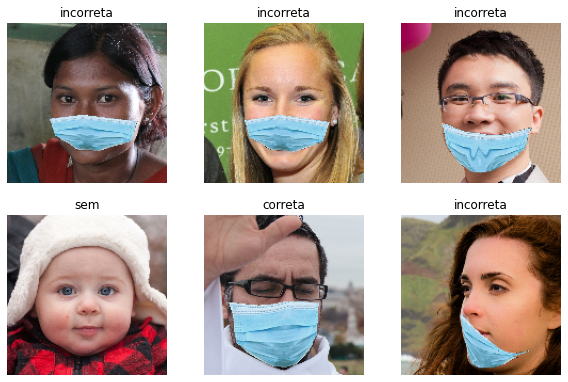

In [25]:
plotar_imagens(train_ds)

# Modelo

- HP do modelo

In [26]:
tx_aprendizagem = 0.0001
epocas = 50

- Podemos criar uma camada de normalização das imagens:

In [27]:
# normalization_layer = tf.keras.layers.Rescaling(1./255, input_shape =image_shape)

- questão de cache das memórias

In [28]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Criação do modelo propriamente falando:

In [29]:
num_classes = 3

https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg19/VGG19

In [31]:
modelo_treinado= tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(150, 150, 3),
    pooling=None,
    classes=num_classes,
    classifier_activation='softmax'
)


#Normalização do pixel
inputs = tf.keras.Input(shape=(150, 150, 3))
normalizacao = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = normalizacao(inputs)
#Construcao do modelo
# model = Sequential()
# model.add(modelo_treinado)
# )
# model.add()
# model.add()
x = modelo_treinado(x, training=False)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x) # Regularize with dropout
x = tf.keras.layers.Dense(150, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)
model.summary()
    

80150528/80134624 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               1228950   
______________________________________________________________

In [32]:
#otimização
opt = Adam(learning_rate=tx_aprendizagem)

In [33]:
# METRICS = [
#     tf.keras.metrics.Accuracy(name="acc"),
#     tf.keras.metrics.Precision(name="precision"),
#     tf.keras.metrics.Recall(name="recall"),
# ]

In [34]:
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics='acc')   #METRICS)
model.summary()

#sparse_categorical_crossentropy ou 'categorical_crossentropy' na função perda


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               1228950   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 453   

# Treinamento

- Treinando...

Existem várias maneiras de combater o overfitting no processo de treinamento, p.e.:
- o aumento de dados
- adicionará Dropout ao seu modelo.

- Cair fora
Outra técnica para reduzir o overfitting é introduzir a regularização de dropout na rede.

Quando você aplica dropout a uma camada, ela descarta aleatoriamente (definindo a ativação como zero) um número de unidades de saída da camada durante o processo de treinamento. Dropout recebe um número fracionário como valor de entrada, na forma de 0,1, 0,2, 0,4, etc. Isso significa descartar 10%, 20% ou 40% das unidades de saída aleatoriamente da camada aplicada.

In [35]:
#Salvando o melhor modelo
checkpoint = ModelCheckpoint('model2-{epoch:03d}.model',monitor='val_accuracy',verbose=0,save_best_only=True,mode='auto')


#Treinando...
history = model.fit(train_ds,
                              epochs=epocas,
                              validation_data=val_ds,
                              callbacks=[checkpoint])

Epoch 1/50
583/583 [==============================] - 794s 1s/step - loss: 0.0424 - acc: 0.9869 - val_loss: 0.0035 - val_acc: 0.9991
Epoch 2/50
583/583 [==============================] - 514s 877ms/step - loss: 0.0082 - acc: 0.9983 - val_loss: 0.0030 - val_acc: 0.9996
Epoch 3/50
583/583 [==============================] - 249s 426ms/step - loss: 0.0081 - acc: 0.9977 - val_loss: 0.0412 - val_acc: 0.9897
Epoch 4/50
583/583 [==============================] - 246s 421ms/step - loss: 0.0132 - acc: 0.9966 - val_loss: 0.0031 - val_acc: 0.9998
Epoch 5/50
583/583 [==============================] - 246s 422ms/step - loss: 0.0046 - acc: 0.9990 - val_loss: 0.0062 - val_acc: 0.9981
Epoch 6/50
583/583 [==============================] - 247s 423ms/step - loss: 0.0136 - acc: 0.9968 - val_loss: 0.0022 - val_acc: 0.9996
Epoch 7/50
583/583 [==============================] - 245s 421ms/step - loss: 0.0055 - acc: 0.9987 - val_loss: 0.0019 - val_acc: 0.9996
Epoch 8/50
583/583 [==============================]

Epoch 38/50
583/583 [==============================] - 242s 415ms/step - loss: 8.1895e-09 - acc: 1.0000 - val_loss: 0.0016 - val_acc: 0.9998
Epoch 39/50
583/583 [==============================] - 242s 416ms/step - loss: 3.9638e-09 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 0.9998
Epoch 40/50
583/583 [==============================] - 242s 414ms/step - loss: 3.5355e-09 - acc: 1.0000 - val_loss: 0.0019 - val_acc: 0.9998
Epoch 41/50
583/583 [==============================] - 241s 414ms/step - loss: 1.7709e-09 - acc: 1.0000 - val_loss: 0.0020 - val_acc: 0.9998
Epoch 42/50
583/583 [==============================] - 241s 414ms/step - loss: 1.8802e-08 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 0.9998
Epoch 43/50
583/583 [==============================] - 242s 414ms/step - loss: 3.1711e-09 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 0.9998
Epoch 44/50
583/583 [==============================] - 241s 414ms/step - loss: 2.4358e-09 - acc: 1.0000 - val_loss: 0.0014 - val_acc: 0.9998
Epoch 45/50
5

In [36]:
#Plotar o desempenho
def processo_treinamento():
  accuracy = history.history['acc']
  val_accuracy = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(epocas)
  plt.gcf().clear()
  plt.figure(figsize = (15, 8))
  plt.subplot(1, 2, 1)
  plt.title('Evolução da Acurácia ao Longo do treinamento')
  plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
  plt.plot(epochs_range, val_accuracy, label = 'Validation Accuracy')
  plt.legend(loc = 'lower right')
  plt.subplot(1, 2, 2)
  plt.title('Evolução da Loss ao Longo do treinamento')
  plt.plot(epochs_range, loss, label = 'Training Loss')
  plt.plot(epochs_range, val_loss, label = 'Validation Loss')
  plt.legend(loc = 'lower right')
  plt.savefig("processo-treinamento-vgg19_ab.png", dpi=300)
  plt.show()
  

<Figure size 432x288 with 0 Axes>

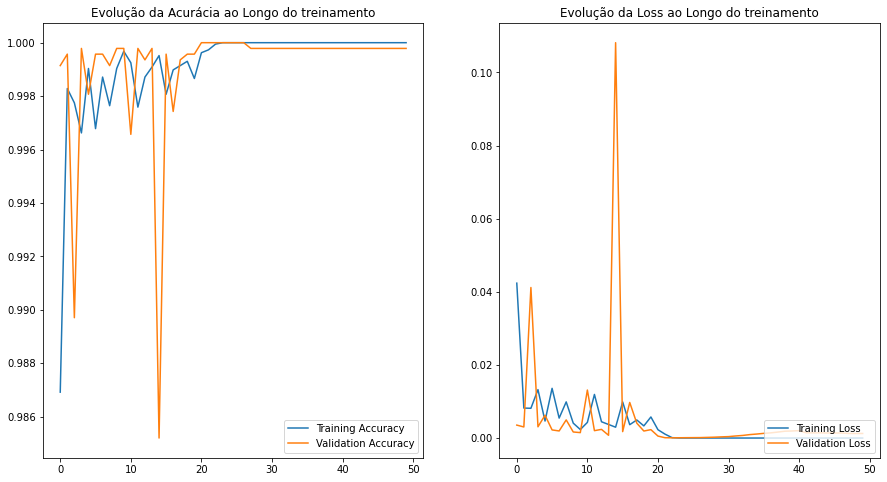

In [37]:
processo_treinamento()  #seria o caso de plotar as outras métricas?

# Salvar o modelo

In [38]:
model.save('modelos/model_p1_vgg19_ab')

INFO:tensorflow:Assets written to: modelos/model_p1_vgg19_ab\assets


# Importando o modelo

In [ ]:
model = load_model('modelos/model_p1_vgg19_ab')

In [39]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 150, 150, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 150)               1228950   
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 453   

### Aplicando o modelo a um dataset de teste

- Nosso dataset de teste:

In [40]:
# dataset_teste = os.path.join('D:/TCC/1/teste', '')
dataset_teste = os.path.join('D:/artigo/mix', '') #Onde estão a pasta train (p1) e test (p1-teste)
# Dataset

In [41]:
data_dir_teste= pathlib.Path(dataset_teste)
data_dir_teste

WindowsPath('D:/artigo/mix')

In [42]:
image_count_t = len(list(data_dir_teste.glob('*/*')))   #ou .jpg
print(image_count_t)

150


In [43]:
list_t = tf.data.Dataset.list_files(str(data_dir_teste) + '/*/*', shuffle=False)
list_t = list_t.shuffle(image_count_t, reshuffle_each_iteration=False)

In [44]:
for f1 in list_t.take(3):
  print(f1.numpy())

b'D:\\artigo\\mix\\sem\\55998.png'
b'D:\\artigo\\mix\\correta\\428_mask.jpg'
b'D:\\artigo\\mix\\correta\\36_mask.jpg'


In [45]:
class_names = np.array(sorted([item.name for item in data_dir_1.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['correta' 'incorreta' 'sem']


In [46]:
val_size_t = int(image_count_t *0)
teste = list_t.skip(val_size_t)
print(tf.data.experimental.cardinality(teste).numpy())

150


In [47]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
teste  = teste.map(process_path, num_parallel_calls=AUTOTUNE)

In [48]:
for image, label in teste.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (150, 150, 3)
Label:  2


In [49]:
#  Configurar conjunto de dados para desempenho
teste = configure_for_performance(teste)

#  questão de cache das memórias
teste =  teste.cache().prefetch(buffer_size=AUTOTUNE)

<Figure size 432x288 with 0 Axes>

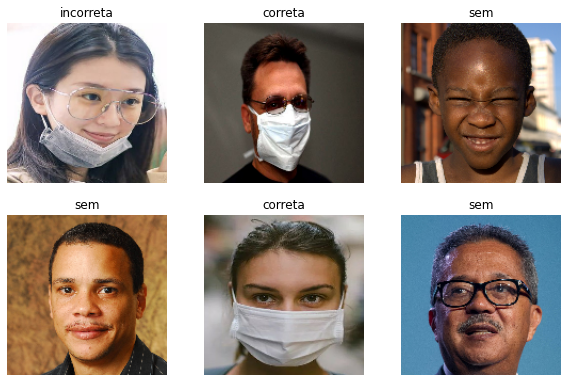

In [50]:
plotar_imagens(teste)

In [51]:
# teste = tf.keras.utils.image_dataset_from_directory(
#   data_dir_teste,
#   image_size=(image_height, image_width),
#   batch_size=batch_size)

In [52]:
classe_real = pd.DataFrame(columns=["real"])
ponteiro = 0
for data in teste.as_numpy_iterator():
    a = class_names[data[1]]
    for i in range(a.size):  # de 0 a 31  
        classe_real.loc[i+ponteiro] = a[i]
    ponteiro= classe_real.shape[0]

In [53]:
classe_real

,real
0,sem
1,incorreta
2,correta
3,sem
4,correta
...,...
145,correta
146,incorreta
147,sem
148,sem


In [54]:
predictions = model.predict(teste)
print(predictions)

[[1.84335276e-18 1.70659404e-16 1.00000000e+00]
 [4.54961318e-13 5.97273200e-08 9.99999881e-01]
 [9.06243563e-01 7.65465052e-11 9.37564522e-02]
 [4.15325533e-16 4.69166874e-14 1.00000000e+00]
 [7.97627450e-11 2.76526968e-10 1.00000000e+00]
 [6.61194183e-16 1.67349885e-13 1.00000000e+00]
 [1.02299891e-17 2.05763573e-15 1.00000000e+00]
 [3.21956541e-08 1.03112831e-10 1.00000000e+00]
 [4.53545881e-12 4.67621630e-09 1.00000000e+00]
 [1.32210767e-17 1.23425120e-15 1.00000000e+00]
 [4.78545346e-08 5.70504460e-03 9.94294941e-01]
 [3.91005215e-14 1.79052148e-10 1.00000000e+00]
 [3.15531238e-12 1.00655140e-09 1.00000000e+00]
 [2.39944393e-14 1.30517486e-10 1.00000000e+00]
 [7.18364421e-20 6.70357028e-17 1.00000000e+00]
 [1.05399922e-18 5.25006406e-17 1.00000000e+00]
 [1.37524692e-09 1.00000000e+00 7.74457054e-10]
 [1.88389526e-09 4.33445075e-06 9.99995708e-01]
 [1.17192715e-15 1.10471777e-12 1.00000000e+00]
 [1.90947484e-14 4.32441274e-13 1.00000000e+00]
 [4.31310236e-17 1.93651349e-14 1.000000

In [55]:
def predicao(predictions):  #predictions é a saída da função predict
    score1 = tf.nn.softmax(predictions)    
    # score1.shape[0]  é a quantidade de predições
    classe = pd.DataFrame(columns=["predito","confianca"])
    for i in range(score1.shape[0]):
        classe.loc[i] = [class_names[np.argmax(score1[i])],100*np.max(score1[i])]   
    return classe

In [56]:
def get_labels_from_tfdataset(tfdataset, batched=False):
    labels = list(map(lambda x: x[1], tfdataset)) # Get labels 
    if not batched:
         return tf.concat(labels, axis=0) # concat the list of batched labels
    return class_names[labels]

In [57]:
get_labels_from_tfdataset(teste)

<tf.Tensor: shape=(150,), dtype=int64, numpy=
array([2, 1, 0, 2, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 2, 2, 1, 1, 1, 2, 2, 2,
       1, 0, 0, 1, 2, 1, 0, 0, 1, 2, 0, 0, 1, 0, 2, 2, 0, 1, 2, 0, 2, 0,
       2, 2, 1, 0, 0, 0, 1, 2, 0, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 0, 0, 1,
       0, 2, 0, 0, 0, 0, 2, 1, 0, 1, 1, 2, 0, 1, 0, 1, 1, 1, 1, 1, 0, 2,
       0, 2, 2, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 0,
       0, 1, 2, 0, 2, 2, 1, 2, 1, 1, 2, 2, 0, 2, 1, 0, 2, 1, 2, 1, 1, 0,
       1, 2, 2, 2, 2, 2, 0, 0, 1, 2, 1, 0, 2, 0, 1, 2, 2, 0], dtype=int64)>

In [58]:
classe_predita = predicao(predictions)
classe_predita

,predito,confianca
0,sem,57.611686
1,sem,57.611686
2,correta,54.118639
3,sem,57.611686
4,sem,57.611686
...,...,...
145,sem,57.607877
146,incorreta,57.611686
147,sem,57.611686
148,sem,57.611686


In [59]:
resultado_df = pd.concat([classe_real, classe_predita],axis=1)
resultado_df

,real,predito,confianca
0,sem,sem,57.611686
1,incorreta,sem,57.611686
2,correta,correta,54.118639
3,sem,sem,57.611686
4,correta,sem,57.611686
...,...,...,...
145,correta,sem,57.607877
146,incorreta,incorreta,57.611686
147,sem,sem,57.611686
148,sem,sem,57.611686


- Avaliação

In [66]:
model.evaluate(teste, return_dict=True)

5/5 [==============================] - 1s 116ms/step - loss: 15.0870 - acc: 0.4200


{'loss': 15.08696460723877, 'acc': 0.41999998688697815}

In [67]:
dataset_test_loss, dataset_test_accuracy = model.evaluate(teste)
print('Dataset Test Loss: %s' % dataset_test_loss)
print('Dataset Test Accuracy: %s' % dataset_test_accuracy)

5/5 [==============================] - 1s 116ms/step - loss: 15.0870 - acc: 0.4200
Dataset Test Loss: 15.08696460723877
Dataset Test Accuracy: 0.41999998688697815


Obs.: Para as outras métricas, utilizar o arquivo avaliacao. Ele irá gerar uma matriz de confusão. Em seguida, com base nos elementos dessa matriz, ele realiza os cálculos das métricas